# Setup

In [1]:
import csv
import pickle
from collections import defaultdict
from pathlib import Path
from pprint import pprint
from timeit import timeit

import numpy as np
import lmdb
import h5py

from PIL import Image

from utils.files import delete

%load_ext autoreload
%autoreload 2

DATA = Path('../data/storing_and_accessing_images')

disk_dir = Path(f'{DATA}/disk')
lmdb_dir = Path(f'{DATA}/lmdb')
hdf5_dir = Path(f'{DATA}/hdf5')

delete(str(disk_dir))
delete(str(lmdb_dir))
delete(str(hdf5_dir))

disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

# A Dataset to Play With

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')


images, labels = [], []
for batch in Path(DATA).glob('cifar-10/data_batch_*'):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b'data']):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack(im_channels))
        # Save the label
        labels.append(batch_data[b'labels'][i])

print('Loaded CIFAR-10 training set:')
print(f' - np.shape(images)     {np.shape(images)}')
print(f' - np.shape(labels)     {np.shape(labels)}')


Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


# Storing a single file

## Disk

In [3]:
def store_single_disk(image, image_id, label):
    """Stores a single image as a .png file on disk.

    Parameters:
    ---------------
    image       image array, (32, 32, 3) to be stored
    image_id    integer unique ID for image
    label       image label
    """
    Image.fromarray(image).save(f'{disk_dir}/{image_id}.png')

    with open(f'{disk_dir}/{image_id}.csv', 'wt') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([label])

## LMDB

In [4]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """Returns the image as a numpy array."""
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

def store_single_lmdb(image, image_id, label):
    """Stores a single image to a LMDB.

    Parameters:
    ---------------
    image       image array, (32, 32, 3) to be stored
    image_id    integer unique ID for image
    label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    with lmdb.open(f'{lmdb_dir}/single_lmdb', map_size=map_size) as env:
        # Start a new write transaction
        with env.begin(write=True) as txn:
            # All key-value pairs need to be strings
            value = CIFAR_Image(image, label)
            key = f'{image_id:08}'
            txn.put(key.encode('ascii'), pickle.dumps(value))


## HDF5

In [5]:
def store_single_hdf5(image, image_id, label):
    """Stores a single image to an HDF5 file.

    Parameters:
    ---------------
    image       image array, (32, 32, 3) to be stored
    image_id    integer unique ID for image
    label       image label
    """
    # Create a new HDF5 file
    with h5py.File(f'{hdf5_dir}/{image_id}.h5', 'w') as file:
        dataset = file.create_dataset(
            'image', np.shape(image), h5py.h5t.STD_U8BE, data=image
        )
        meta_set = file.create_dataset(
            'meta', np.shape(label), h5py.h5t.STD_U8BE, data=label
        )


## Experiments for Storing a Single Image

In [6]:
methods = {
    'disk': store_single_disk,
    'lmdb': store_single_lmdb,
    'hdf5': store_single_hdf5
}

timings = {}
for method, f in methods.items():
    t = timeit(
        'f(image, 0, label)',
        setup='image=images[0]; label=labels[0]',
        number=1,
        globals=globals(),
    )
    timings[method] = t
    print(f'Method: {method}, Time usage: {t}')

"""
RealPython's results
| Method | Save Single Image + Meta | Memory |
| ------ | ------------------------:| ------:|
| Disk   |                 1.915 ms |    8 K |
| LMDB   |                 1.203 ms |   32 K |
| HDF5   |                 8.243 ms |    8 K |

My results on the lenovo (on ext HDD) with n=1:
| Method | Save Single Image + Meta |
| ------ | ------------------------:|
| Disk   |                 7.577 ms |
| LMDB   |               995.785 ms |
| HDF5   |                 3.732 ms |
""";

Method: disk, Time usage: 0.007541282000033789
Method: lmdb, Time usage: 0.48452658300004714
Method: hdf5, Time usage: 0.0018682179999132131


# Storing Many Images


## Disk

In [0]:
def store_many_disk(images, labels):
    """Stores an array of images to disk

    Parameters:
    ---------------
    images       images array, (N, 32, 32, 3) to be stored
    labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)
    for i, image in enumerate(images):
        Image.fromarray(image).save(f'{disk_dir}/{i}.png')

    with open(disk_dir / f'{num_images}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for label in labels:
            writer.writerow([label])

## LMDB

In [0]:
def store_many_lmdb(images, labels):
    """Stores an array of images to LMDB.

    Parameters:
    ---------------
    images       images array, (N, 32, 32, 3) to be stored
    labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)
    map_size = num_images * images[0].nbytes * 10
    with lmdb.open(f'{lmdb_dir}/{num_images}_lmdb', map_size=map_size) as env:
        # Same as before — but let's write all the images in a single transaction
        with env.begin(write=True) as txn:
            for i in range(num_images):
                value = CIFAR_Image(images[i], labels[i])
                key = f'{i:08}'
                txn.put(key.encode('ascii'), pickle.dumps(value))


## HDF5

In [23]:
def store_many_hdf5(images, labels):
    """Stores an array of images to HDF5.

    Parameters:
    ---------------
    images       images array, (N, 32, 32, 3) to be stored
    labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)
    with h5py.File(f'{hdf5_dir}/{num_images}_many.h5', 'w') as file:
        dataset = file.create_dataset(
            'images', np.shape(images), h5py.h5t.STD_U8BE, data=images
        )
        meta_set = file.create_dataset(
            'meta', np.shape(labels), h5py.h5t.STD_U8BE, data=labels
        )


## Preparing the Dataset

In [8]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))


(100000, 32, 32, 3)
(100000,)


## Experiment for Storing Many Images


In [9]:
methods_many = {
    'disk': store_many_disk,
    'lmdb': store_many_lmdb,
    'hdf5': store_many_hdf5
}

timings_many = defaultdict(list)
for cutoff in cutoffs:
    print()
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "methods_many[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        timings_many[method].append(t)

        print(f"{cutoff: >6} | {method} | {t}")



    10 | disk | 0.0038187079999261186
    10 | lmdb | 0.0945902760000763
    10 | hdf5 | 0.0012270780000562809

   100 | disk | 0.03232610099996691
   100 | lmdb | 0.9943035869999903
   100 | hdf5 | 0.0021061969999891517

  1000 | disk | 0.32489993800004413
  1000 | lmdb | 1.3405985179999789
  1000 | hdf5 | 0.004305885999997372

 10000 | disk | 2.8665681190000214
 10000 | lmdb | 1.2278169879999723
 10000 | hdf5 | 0.026396729999987656

100000 | disk | 30.030387824999934
100000 | lmdb | 10.971426923000081
100000 | hdf5 | 0.2783017489999793


## Plot Timings

/tmp/ipykernel_5945/3784570925.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


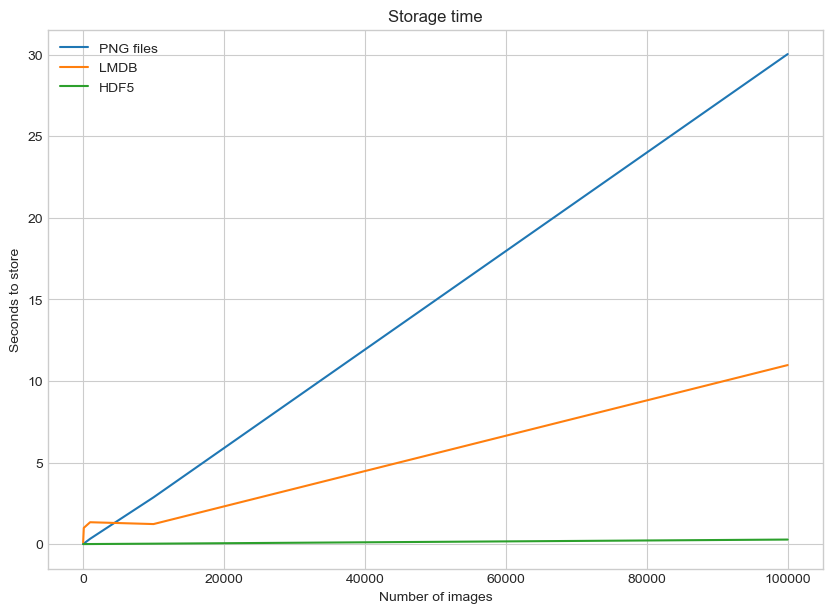

/tmp/ipykernel_5945/3784570925.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


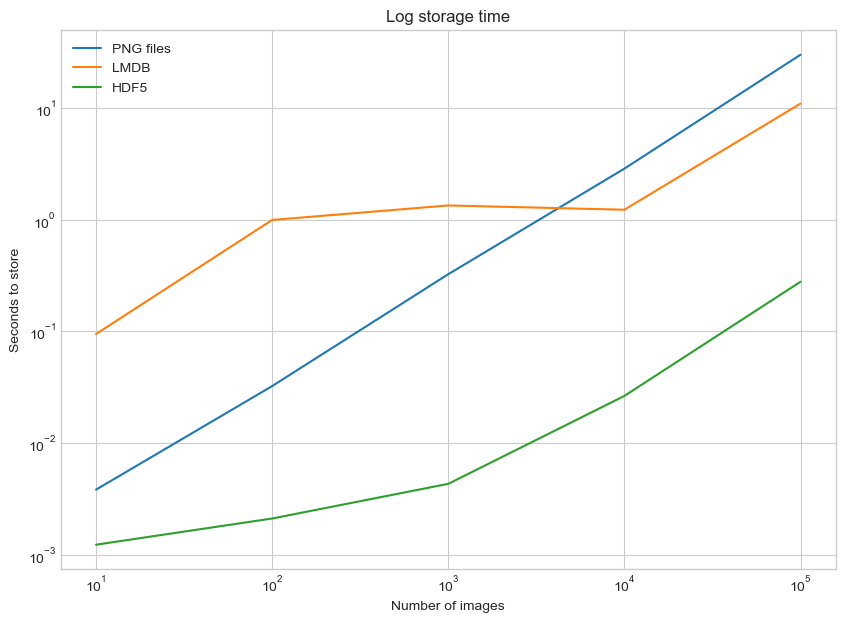

In [10]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = timings_many["disk"]
lmdb_x = timings_many["lmdb"]
hdf5_x = timings_many["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)


# Reading a Single Image


## Disk


In [12]:
def read_single_disk(image_id):
    """Stores a single image to disk.
    Parameters:
    ---------------
    image_id    integer unique ID for image

    Returns:
    ----------
    image       image array, (32, 32, 3) to be stored
    label       associated meta data, int label
    """
    image = np.array(Image.open(f'{disk_dir}/{image_id}.png'))

    with open(f'{disk_dir}/{image_id}.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        label = int(next(reader)[0])

    return image, label

## LMDB


In [13]:
def read_single_lmdb(image_id):
    """Stores a single image to LMDB.
    Parameters:
    ---------------
    image_id    integer unique ID for image

    Returns:
    ----------
    image       image array, (32, 32, 3) to be stored
    label       associated meta data, int label
    """
    with lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True) as env:
        with env.begin() as txn:
            data = txn.get(f"{image_id:08}".encode("ascii"))
            cifar_image = pickle.loads(data)
            image = cifar_image.get_image()
            label = cifar_image.label

    return image, label


## HDF5

In [14]:
def read_single_hdf5(image_id):
    """Stores a single image to HDF5.
    Parameters:
    ---------------
    image_id    integer unique ID for image

    Returns:
    ----------
    image       image array, (32, 32, 3) to be stored
    label       associated meta data, int label
    """
    with h5py.File(f'{hdf5_dir}/{image_id}.h5', 'r+') as file:
        image = np.array(file['/image']).astype('uint8')
        label = int(np.array(file['/meta']).astype('uint8'))

    return image, label


## Experiment for Reading a Single Image

In [15]:
_read_single_funcs = {
    'disk': read_single_disk,
    'lmdb': read_single_lmdb,
    'hdf5': read_single_hdf5
}

read_single_timings = {}
for method, f in _read_single_funcs.items():
    t = timeit(
        "f(0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")


Method: disk, Time usage: 0.0005127290000928042
Method: lmdb, Time usage: 0.0004138640001656313
Method: hdf5, Time usage: 0.0016019330000744958


# Reading Many Images

## Disk

In [19]:
def read_many_disk(num_images):
    """Reads image from disk.
    Parameters:
    ---------------
    num_images   number of images to read

    Returns:
    ----------
    images      images array, (N, 32, 32, 3) to be stored
    labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(f'{disk_dir}/{image_id}.png')))

    with open(disk_dir / f'{num_images}.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            labels.append(int(row[0]))

    return images, labels

## LMDB

In [20]:
def read_many_lmdb(num_images):
    """Reads image from LMDB.
    Parameters:
    ---------------
    num_images   number of images to read

    Returns:
    ----------
    images      images array, (N, 32, 32, 3) to be stored
    labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    with lmdb.open(f'{lmdb_dir}/{num_images}_lmdb', readonly=True) as env:
        with env.begin() as txn:
            for image_id in range(num_images):
                data = txn.get(f'{image_id:08}'.encode('ascii'))
                cifar_image = pickle.loads(data)
                images.append(cifar_image.get_image())
                labels.append(cifar_image.label)

    return images, labels

## HDF5

In [21]:

def read_many_hdf5(num_images):
    """Reads image from HDF5.
    Parameters:
    ---------------
    num_images   number of images to read

    Returns:
    ----------
    images      images array, (N, 32, 32, 3) to be stored
    labels      associated meta data, int label (N, 1)
    """
    with h5py.File(f'{hdf5_dir}/{num_images}_many.h5', 'r+') as file:
        images = np.array(file['/images']).astype('uint8')
        labels = np.array(file['/meta']).astype('uint8')

    return images, labels

## Experiment for Reading Many Images

In [25]:
_read_many_funcs = {
    'disk': read_many_disk,
    'lmdb': read_many_lmdb,
    'hdf5': read_many_hdf5
}

read_many_timings = defaultdict(list)
for cutoff in cutoffs:
    print()
    for method, f in _read_many_funcs.items():
        t = timeit(
            "f(num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)
        print(f"{cutoff: >6} | {method} | {t}")


    10 | disk | 0.0034728509999695234
    10 | lmdb | 0.0004367129999991448
    10 | hdf5 | 0.0019878849998349324

   100 | disk | 0.028123929999765096
   100 | lmdb | 0.002846354000212159
   100 | hdf5 | 0.002154863000214391

  1000 | disk | 0.18458244800012835
  1000 | lmdb | 0.011693205000028684
  1000 | hdf5 | 0.0031633369999326533

 10000 | disk | 1.5247898620000342
 10000 | lmdb | 0.09319651099986004
 10000 | hdf5 | 0.013192685999911191

100000 | disk | 14.819400709000092
100000 | lmdb | 1.00051260500004
100000 | hdf5 | 0.276127679000183


## Plot timings


/tmp/ipykernel_5945/3784570925.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


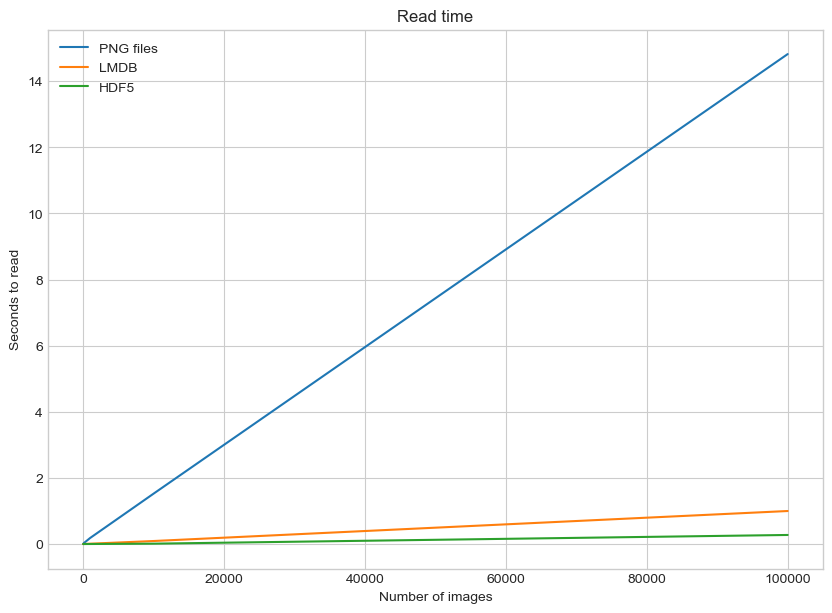

/tmp/ipykernel_5945/3784570925.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


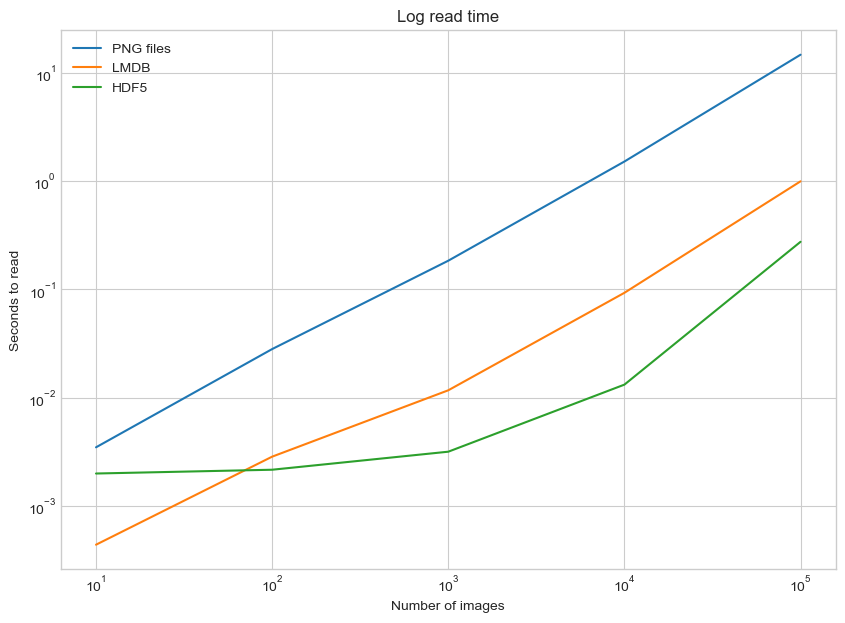

In [26]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)
